**Considering your reading experience, please install the catalog before reading.(https://zhuanlan.zhihu.com/p/24029578)**

# Data Preprocessing

- 剔除缺失率高的变量（比如缺失5%、10%以上）；
  - 但剔除后需要与医生沟通，像**广妇儿CCU死亡预测课题**，就存在大量的缺失值，但不能强行去剔除；
  - NAN不一定代表为**空**，有可能是代表为**0**，这个需要问医生确定。
- 剔除极度偏差的数据，比如二分类变量里，**阳性或是**的个数只有几个，那就不要了。同上，剔除后需要与医生沟通；
- 文本数据处理，根据医生给予的***keywords***对文本变量进行转化，比如一大段文字最后变成了**是否肺炎**，需要问医生，想在文本里提取什么东西？
- 医生的另外需求
  - 比如需要获得一个共病（**高血压-糖尿病**）；
  - 对某些连续变量进行**二值化(0/1)**（能二值化的尽量让医生进行转化，因为二分类变量的解读会更清晰）

## Load Data

In [1]:
import pandas as pd
data = pd.read_excel('./data/02_cleaned_data_20210125.xlsx')

# 删除包含 “术后”，“住院天数”，“费用” 的变量
useless_columns = []
for n in data.columns:
    if '术后' in n or '实际住院天数' in n or '费' in n:
        useless_columns.append(n)
        
useless_columns.remove('术后并发症_呼吸系统_肺炎_术后并发症名称')
data.drop(useless_columns, axis=1, inplace=True)

# 删除医生想删掉的变量
data.drop([
    '术前情况_术前人工肝(血浆置换)',
    '术前情况_术前CRRT',
    '术前情况-术前合并疾病_泌尿系统_急性肾损伤_术前合并疾病名称'
], axis=1, inplace=True)

# 删除极度偏差的变量
for n in data.columns:
#     print(n)
    if (len(data) - data[n].value_counts().tolist()[0]) < 10:
        data.drop(n, axis=1, inplace=True)

In [2]:
data

,人口信息_年龄(年),人口信息_性别,人口信息_ABO血型,体格检查_ASA分级,医嘱项目_糖皮质激素类_地塞米松_医嘱项目名称,医嘱项目_糖皮质激素类_甲泼尼龙_医嘱项目名称,医嘱项目_吸入性糖皮质激素_布地奈德_医嘱项目名称,医嘱项目_祛痰药及抗氧化药_氨溴索_医嘱项目名称,医嘱项目_镇咳药_复方甲氧那明_医嘱项目名称,医嘱项目_短效抗胆碱能药物_异丙托溴铵_医嘱项目名称,...,生命体征_体征信息_收缩压(mmHg)_体征测量结果,生命体征_体征信息_体温(℃)_体征测量结果,生命体征_体征信息_脉搏(次/分)_体征测量结果,生命体征_体征信息_心率(次/分)_体征测量结果,生命体征_体征信息_尿量（ml）_体征测量结果,生命体征_体征信息_日出液量(ml)_体征测量结果,生命体征_体征信息_日总入量(ml)_体征测量结果,生命体征计算指标_术前发热分级,生命体征计算指标_术前发热（体温≥37.3℃）,术后并发症_呼吸系统_肺炎_术后并发症名称
0,44,0,0,0,0,1,1,1,0,1,...,153.000000,36.700000,81.000000,82.000000,93.750000,93.750000,111.666667,0,0,0
1,42,1,1,0,0,1,1,1,0,1,...,154.599896,36.626153,81.029323,84.850077,174.627376,181.569924,170.342823,0,0,0
2,39,1,0,0,0,1,1,1,0,1,...,132.000000,36.600000,96.000000,105.000000,13.375000,44.625000,101.666667,0,0,0
3,62,1,0,0,0,0,0,0,0,0,...,154.000000,37.200000,82.000000,76.000000,79.166667,83.541667,53.416667,0,0,0
4,48,0,1,0,0,1,1,1,0,1,...,167.000000,36.900000,86.000000,120.000000,240.000000,241.000000,212.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,46,1,2,0,0,1,0,1,0,1,...,107.000000,37.000000,93.000000,108.000000,101.250000,103.333333,90.833333,0,0,0
713,26,1,1,0,0,1,1,1,0,1,...,162.000000,36.700000,72.000000,146.000000,38.750000,47.083333,31.250000,0,0,0
714,33,1,0,0,0,1,1,1,0,1,...,173.000000,36.700000,72.000000,85.000000,143.333333,149.583333,147.500000,0,0,1
715,54,1,3,0,0,0,0,0,0,0,...,114.000000,36.700000,96.000000,84.000000,186.666667,189.791667,182.500000,0,0,0


In [3]:
data.shape

(717, 110)

## Feature Engineering

- 合并 “高血压”，“糖尿病”得到共病

In [4]:
hypertension = data['术前情况-术前合并疾病_循环系统_高血压_术前合并疾病名称']
diabetes = data['术前情况-术前合并疾病_内分泌系统_糖尿病_术前合并疾病名称']

merge_hy_di = []

for h,d in zip(hypertension, diabetes):
    if h == 1 and d == 1:
        merge_hy_di.append(1)
    else:
        merge_hy_di.append(0)
        
data['高血压_糖尿病_共病'] = merge_hy_di
# risk_fators_columns.append('高血压_糖尿病_共病')

## Descriptive Statistic

- 调用 ClinicalTools 的 Aid 类，对数据进行描述统计，分类卡方，连续T-test
- 此外，还有单因素多因素分析、逐步回归分析；

In [5]:
from ClinicalTools.preprocessing import Aid

aid = Aid(label = '术后并发症_呼吸系统_肺炎_术后并发症名称', dataframe = data, class_threshold=3)
group0 = data.query('术后并发症_呼吸系统_肺炎_术后并发症名称 == 0')
group1 = data.query('术后并发症_呼吸系统_肺炎_术后并发症名称 == 1')
full_stat = aid.stats_table(data, group0, group1, decimal = 3)

Categorical variables: 56 (55 binary variables ,1 multi-category variables);              
Continuous variables: 54;
OOV variables: []
Target Label: 术后并发症_呼吸系统_肺炎_术后并发症名称;
No variable is valid for parametric test


In [6]:
pd.set_option('display.max_rows', 200)
full_stat

,All(N=717),Group 0(n=598),Group 1(n=119),Statistics,P_value
人口信息_年龄(年),43.25(11.69),42.61(11.64),46.46(11.44),11.378,0.001
人口信息_ABO血型,0.97(0.98),0.96(0.97),1.04(1.04),0.46,0.497
医嘱计算指标_术前红细胞输注量（U）,0.1(0.98),0.05(0.33),0.35(2.27),3.26,0.071
医嘱计算指标_术前白蛋白输注量(ml),105.45(145.24),97.25(99.47),146.64(275.46),1.854,0.173
医嘱计算指标_术前人免疫球蛋白（丙种球蛋白）输注量(g),0.75(5.02),0.5(2.28),2.02(11.17),4.825,0.028
手术基本信息_手术时长(min),202.61(54.56),202.59(55.6),202.72(49.25),0.129,0.719
手术基本信息_麻醉时长(min),277.18(83.86),277.7(87.6),274.59(61.94),0.001,0.971
手术用药_皮质激素_甲强龙_使用总量,187.06(299.83),188.93(311.09),177.66(236.11),0.01,0.922
术中入出量_多巴酚丁胺术中输注量,1.16(4.66),1.1(4.49),1.47(5.48),0.768,0.381
术中入出量_胶体,4.57(38.62),3.89(35.13),7.98(52.88),0.847,0.357


## *p<0.05* Features selection

- 分类变量卡方检验，连续变量T检验，筛选出*P*<0.05的变量。

In [7]:
from ClinicalTools.preprocessing import p_sele
x_columns = p_sele(full_stat)

In [8]:
len(x_columns)

18

In [9]:
x_columns

['人口信息_年龄(年)',
 '医嘱计算指标_术前人免疫球蛋白（丙种球蛋白）输注量(g)',
 '术中入出量_红细胞',
 '检验项目_凝血功能_纤维蛋白原浓度Fib_g/l_检验结果',
 '检验项目_生化_总胆固醇CHOL_检验结果',
 '检验项目_生化_低密度脂蛋白胆固醇LDL_C_检验结果',
 '生命体征_体征信息_尿量（ml）_体征测量结果',
 '生命体征_体征信息_日出液量(ml)_体征测量结果',
 '生命体征_体征信息_日总入量(ml)_体征测量结果',
 '医嘱项目_糖皮质激素类_地塞米松_医嘱项目名称',
 '医嘱项目_吸入性糖皮质激素_布地奈德_医嘱项目名称',
 '医嘱项目_镇咳药_复方甲氧那明_医嘱项目名称',
 '医嘱项目_抗病毒药物_更昔洛韦_医嘱项目名称',
 '是否全麻',
 '手术用药_血管活性药物（循环系统用药）_肾上腺素_药品名称',
 '手术用药_心肌营养药_磷酸肌酸钠_药品名称',
 '手术用药_止呕药_万唯_药品名称',
 '术前情况_术前气管插管']

## Create X and y

In [10]:
X = data[x_columns]
y = data['术后并发症_呼吸系统_肺炎_术后并发症名称']

In [11]:
X.shape, y.shape

((717, 18), (717,))

## Rename Columns

- 这里要做一个中英文对照表，结构如下，方便更替变量名字

|  原始名称   | 标准中文名称  | 英文名称 |
|  ----  | ----  | ---- |
| 人口信息_年龄(年)|年龄|Age|

In [12]:
eng_names = pd.read_excel('./data/中英文对照表.xls')
chi = eng_names['原始名称']
eng = eng_names['英文名称']

for c,e in zip(chi, eng):
    X.rename(columns={
        c: e
    }, inplace=True)

In [13]:
X

,Age,Preoperative Human Immunoglobulin infusion,Intraoperative Red Blood Cells Transfusion,Admission Fbrinogen,Admission Total Cholesterol,Admission Low Density Lipoprotein Cholesterol,Urine Volume On The First Postoperative Day,Fluid Output On The First Postoperative Day,Fluid Intake On The First Postoperative Day,Dexamethasone,Inhaled Budesonide,Compound Methoxyphenamine Hydrochloride,Ganciclovir,Only General Anesthesia,Adrenaline,Creatine Phosphate Sodium,Azasetron,Preoperative Endotracheal Intubation
0,44,0.0,240.0,4.83,7.42,4.71,93.750000,93.750000,111.666667,0,1,0,1,1,0,0,0,0
1,42,0.0,0.0,3.28,5.29,3.37,174.627376,181.569924,170.342823,0,1,0,1,1,0,0,0,0
2,39,0.0,0.0,4.14,4.01,2.14,13.375000,44.625000,101.666667,0,1,0,1,1,0,0,0,0
3,62,0.0,0.0,4.43,4.05,2.05,79.166667,83.541667,53.416667,0,0,0,0,1,0,0,0,0
4,48,11.0,0.0,5.51,6.40,3.91,240.000000,241.000000,212.000000,0,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,46,0.0,0.0,3.57,4.54,2.01,101.250000,103.333333,90.833333,0,0,0,0,1,0,0,0,0
713,26,0.0,0.0,2.90,4.14,2.73,38.750000,47.083333,31.250000,0,1,0,0,1,0,0,0,0
714,33,0.0,0.0,2.08,2.44,1.39,143.333333,149.583333,147.500000,0,1,0,1,1,0,0,0,0
715,54,0.0,250.0,4.86,4.97,2.89,186.666667,189.791667,182.500000,0,0,0,0,1,0,0,0,0


- 做一版英文的描述统计表

In [14]:
data2 = pd.concat([X, y], axis=1)

aid = Aid(label = '术后并发症_呼吸系统_肺炎_术后并发症名称', dataframe = data2, class_threshold=3)
group0 = data2.query('术后并发症_呼吸系统_肺炎_术后并发症名称 == 0')
group1 = data2.query('术后并发症_呼吸系统_肺炎_术后并发症名称 == 1')
full_stat = aid.stats_table(data2, group0, group1, decimal = 3)

Categorical variables: 9 (9 binary variables ,0 multi-category variables);              
Continuous variables: 9;
OOV variables: []
Target Label: 术后并发症_呼吸系统_肺炎_术后并发症名称;
No variable is valid for parametric test


In [15]:
full_stat

,All(N=717),Group 0(n=598),Group 1(n=119),Statistics,P_value
Age,43.25(11.69),42.61(11.64),46.46(11.44),11.378,0.001
Preoperative Human Immunoglobulin infusion,0.75(5.02),0.5(2.28),2.02(11.17),4.825,0.028
Intraoperative Red Blood Cells Transfusion,69.86(175.34),77.07(184.91),33.64(109.47),4.725,0.03
Admission Fbrinogen,4.25(1.18),4.2(1.18),4.5(1.14),7.452,0.006
Admission Total Cholesterol,4.49(1.15),4.42(1.11),4.84(1.3),10.243,0.001
Admission Low Density Lipoprotein Cholesterol,2.45(0.86),2.39(0.81),2.73(1.01),10.907,0.001
Urine Volume On The First Postoperative Day,189.93(176.06),201.25(182.06),133.01(128.28),21.968,<0.001
Fluid Output On The First Postoperative Day,196.24(157.82),206.64(160.83),143.99(130.27),19.423,<0.001
Fluid Intake On The First Postoperative Day,174.0(126.28),181.59(128.86),135.85(104.87),14.691,<0.001
Dexamethasone,51(7.113%),34(5.686%),17(14.286%),9.847,0.002


# Machine Learning Models

## pre

### Split Training Set and Test Set

数据集命名问题：

- 当只切割两个数据集，直接使用：**Training set**, **Test set**
- test_size设置: 0.2, 0.25, 0.3 进行测试，优先考虑0.3
- 当有外部验证集的时候，用下图命名：

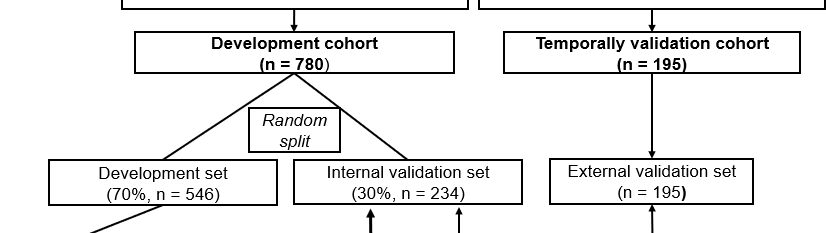

In [16]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

### 切分测试集与验证集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train = X_train.reset_index().drop('index', axis=1)
X_test = X_test.reset_index().drop('index', axis=1)
y_train = y_train.reset_index().drop('index', axis=1)
y_test = y_test.reset_index().drop('index', axis=1)

In [17]:
X_train.shape, X_test.shape

((501, 18), (216, 18))

### Check Missing Rate and Impute by MICE or Mean

In [18]:
# 检查是否缺失，案例数据比较完整，不需要补；
for n in X.columns:
    missing_num = len(X[X[n].isna()])
    if missing_num != 0:
        print(n, missing_num)

- 直接均值补全，pd.fillna(X_train.mean())
- 使用MICE，MICE的最佳用法，应该是使用***R***的MICE，
    - 分类变量用 众数;
    - 连续变量用 MICE;
    - **顺序需先分类变量补，再连续变量补，因为MICE差值的时候，会用到分类的列**

In [19]:
'''
分类变量用众数补，连续变量用MICE补；需要用到，把注释取消掉；
'''
from ClinicalTools.preprocessing import impute_category_with_mode
from ClinicalTools.preprocessing import impute_continue_with_mice

# # step1: categroy vars, classes is the length of value_counts()
# X_train, X_test = impute_category_with_mode(X_train, X_test, classes=5)
# # step2: continue vars
# X_train, X_test = impute_continue_with_mice(X_train, X_test)

### Cheak Training Set and Test Set

- Check whether the distribution of the training set and the test set are consistent
- 分类卡方，连续T检验

In [20]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [21]:
from ClinicalTools.preprocessing import base_sta

sta_df = base_sta(train, test)
sta_df

,Characteristics,Subtype,train,test,p_values
10,Adrenaline,0.0,490(97.8%),208(96.3%),1
11,Adrenaline,1.0,11(2.2%),8(3.7%),1
14,Azasetron,0.0,474(94.61%),198(91.67%),0.998852
15,Azasetron,1.0,27(5.39%),18(8.33%),0.998852
4,Compound Methoxyphenamine Hydrochloride,0.0,492(98.2%),208(96.3%),1
5,Compound Methoxyphenamine Hydrochloride,1.0,9(1.8%),8(3.7%),1
12,Creatine Phosphate Sodium,0.0,493(98.4%),213(98.61%),1
13,Creatine Phosphate Sodium,1.0,8(1.6%),3(1.39%),1
0,Dexamethasone,0.0,460(91.82%),206(95.37%),0.986611
1,Dexamethasone,1.0,41(8.18%),10(4.63%),0.986611


### Continue Variablies Standardzation

- 对连续变量进行标准化，这里建议是直接用数学公式进行计算，因为后续的web网站需要用到这些参数，如果直接用sklearn的Standardization，会出现变量个数不匹配问题，因为后面会进行LASSO/RFE的变量筛选；
- 使用封装的 StandardScaler，可以避免上述问题；
- threshold 是分类连续变量 value_counts() 分界；

In [22]:
from ClinicalTools.preprocessing import StandardScaler

standard = StandardScaler(threshold=3)
standard.fit(X_train)
X_train = standard.transform(X_train)
X_test = standard.transform(X_test)

In [23]:
# continue vars
standard.standard_df

,Age,Preoperative Human Immunoglobulin infusion,Intraoperative Red Blood Cells Transfusion,Admission Fbrinogen,Admission Total Cholesterol,Admission Low Density Lipoprotein Cholesterol,Urine Volume On The First Postoperative Day,Fluid Output On The First Postoperative Day,Fluid Intake On The First Postoperative Day
mean,43.279441,0.867265,69.703213,4.260958,4.494684,2.455930,194.791032,199.889870,177.426062
std,11.786937,5.787905,172.437917,1.180426,1.163439,0.879036,188.425417,163.534134,128.828967


### Features Selection (Lasso OR RFE)

- 二选一即可，看哪个方法筛选出来的变量更合理，更少;

In [24]:
from ClinicalTools.models import lasso_sele

lasso_select_vars = lasso_sele(X_train, y_train)

利用Lasso交叉检验计算得出的最优alpha：0.0015297802594738984
Lasso回归后系数不为0的个数: 16


In [25]:
X_train = X_train[lasso_select_vars]
X_test = X_test[lasso_select_vars]

## Train Machine Learning Modes 

### GridSearch

- 基础模型网格搜索（LR, SVC, GNB, RF, GBM, ADA, MLP)

In [26]:
# 使用封装好的 GridSearch 包，进行网格搜索
from ClinicalTools.models import multi_best_models
# 返回每个最佳参数模型
models = multi_best_models(X_train, y_train, cv=5)

Logistic Regression
Tuned hyper-parameters:(best parameters)  {'C': 0.0001, 'max_iter': 100, 'penalty': 'none', 'solver': 'saga'}
Accuracy: 0.697
Consume Time: 0:00:05

Support Vector Classification
Tuned hyper-parameters:(best parameters)  {'C': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
Accuracy: 0.68
Consume Time: 0:00:01

Gaussian NB
Tuned hyper-parameters:(best parameters)  {'var_smoothing': 0.004641588833612782}
Accuracy: 0.723
Consume Time: 0:00:00

Random Forest Classification
Tuned hyper-parameters:(best parameters)  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.659
Consume Time: 0:00:22

Gradient Boosting Decision Classification
Tuned hyper-parameters:(best parameters)  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40}
Accuracy: 0.6

In [27]:
from ClinicalTools.metrics import bootstrap
bootstrap_df = bootstrap(X_test, y_test, models,
                         precision=3, random_state=0) 

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 380.29it/s]


In [28]:
bootstrap_df

,AUC,Accuracy,Sensitivity,Specificity,F1
LR,"0.722(0.625, 0.813)","0.69(0.63, 0.75)","0.636(0.476, 0.792)","0.698(0.629, 0.768)","0.403(0.294, 0.516)"
SVC,"0.711(0.619, 0.8)","0.667(0.606, 0.731)","0.636(0.475, 0.8)","0.674(0.604, 0.742)","0.385(0.273, 0.5)"
GNB,"0.735(0.636, 0.826)","0.838(0.787, 0.884)","0.444(0.286, 0.607)","0.914(0.871, 0.954)","0.471(0.314, 0.603)"
RF,"0.683(0.566, 0.782)","0.611(0.542, 0.681)","0.639(0.483, 0.784)","0.604(0.528, 0.678)","0.35(0.237, 0.446)"
GBM,"0.715(0.607, 0.812)","0.847(0.796, 0.894)","0.135(0.033, 0.269)","0.989(0.971, 1.0)","0.227(0.061, 0.4)"
ADA,"0.677(0.562, 0.78)","0.852(0.806, 0.898)","0.135(0.031, 0.25)","0.995(0.983, 1.0)","0.233(0.059, 0.39)"
MLP,"0.719(0.624, 0.816)","0.843(0.792, 0.889)","0.136(0.033, 0.268)","0.984(0.962, 1.0)","0.226(0.057, 0.4)"


### Bulid Stacking Model

**stacking** OR **soft voting**的模型改进

- 对于**soft voting**，把所有基础模型集成使用（优先考虑）
- 对于**stacking**，需要多次尝试，模型图如下，两层的模型选择都需要多次尝试。（Tips: 可以先尝试所有的baseline models，若结果不理想；则考虑如图所示，top n 个模型作为基础学习器）

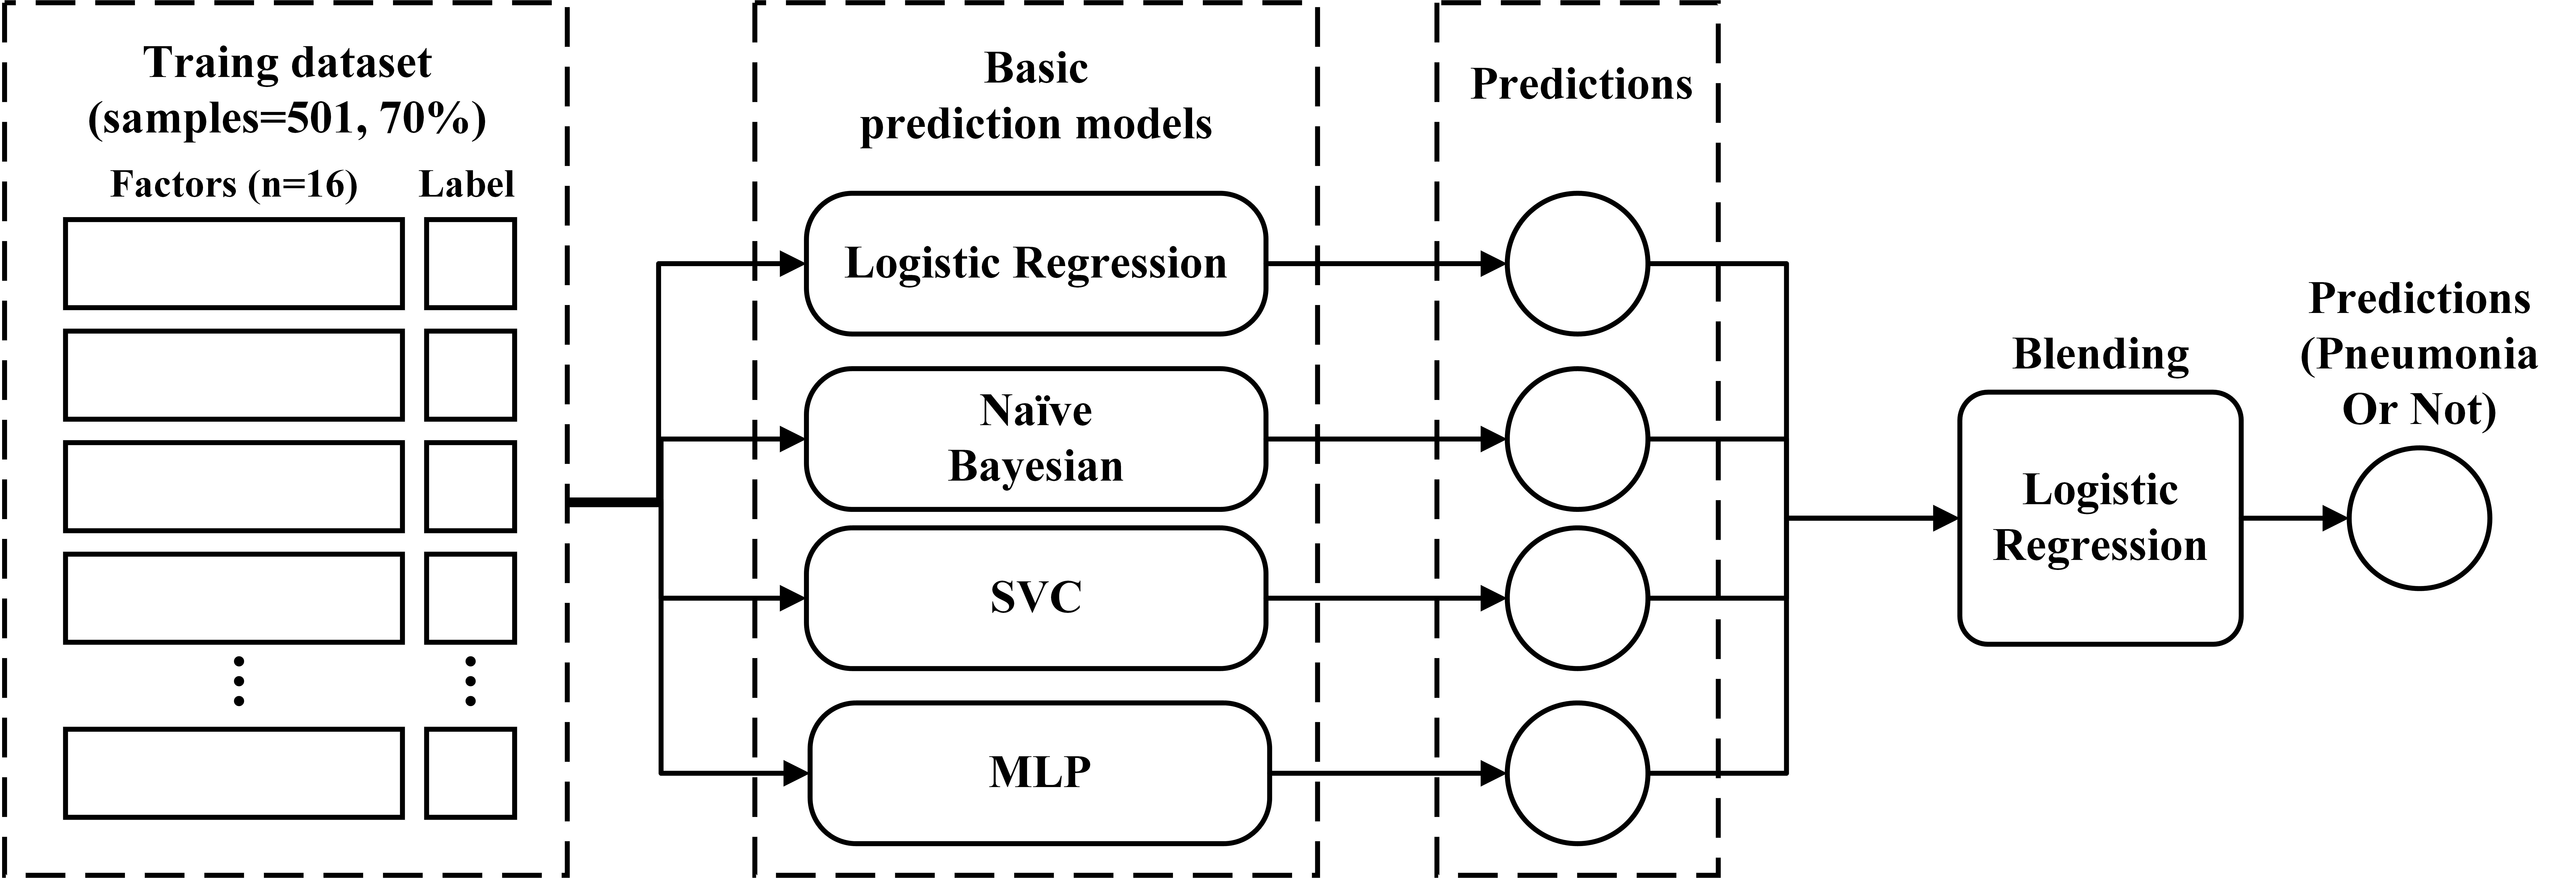

In [29]:
'''
Stacking model example

使用 top 4 baseline models 作为第一层学习器；
使用 LR 作为第二层学习器；
经验调整，需多次尝试。
'''
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
estimators = [
    ('lr', models[0]),
    ('SVC', models[1]),
    ('GNB', models[2]),
    ('MLP', models[6]),
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=models[0])
# voting_clf = VotingClassifier(estimators=estimators, voting='soft')

stacking_clf.fit(X_train, y_train)
stacking_prob = stacking_clf.predict_proba(X_test)[:, 1]
stacking_prediction = stacking_clf.predict(X_test)

from ClinicalTools.metrics import auc_acc_sen_spe_f1_scores

print(auc_acc_sen_spe_f1_scores(y_test, stacking_prediction, stacking_prob))

        AUC  Accuracy        F1  Sensitivity  Specificity
0  0.742284  0.731481  0.431373     0.611111     0.755556


In [30]:
# append stacking model
models.append(stacking_clf)

### Bootstrap Scores

- models 为前面的 model_cv 得到的，可以append新的模型进去，比如stacking model，前提是该 model 能计算出 prob
- index_names 需要跟 models 匹配得上
- random_state 默认 42
- precision 默认 3

In [31]:
bootstrap_df = bootstrap(X_test, y_test, models,
                         index_names=['LR', 'SVC', 'GNB', 'RF', 'GBM', 'ADA', 'MLP', 'Stacking model'],
                         precision=3, random_state=0) 

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.68it/s]


In [32]:
bootstrap_df

,AUC,Accuracy,Sensitivity,Specificity,F1
LR,"0.722(0.625, 0.813)","0.69(0.63, 0.75)","0.636(0.476, 0.792)","0.698(0.629, 0.768)","0.403(0.294, 0.516)"
SVC,"0.711(0.619, 0.8)","0.667(0.606, 0.731)","0.636(0.475, 0.8)","0.674(0.604, 0.742)","0.385(0.273, 0.5)"
GNB,"0.735(0.636, 0.826)","0.838(0.787, 0.884)","0.444(0.286, 0.607)","0.914(0.871, 0.954)","0.471(0.314, 0.603)"
RF,"0.683(0.566, 0.782)","0.611(0.542, 0.681)","0.639(0.483, 0.784)","0.604(0.528, 0.678)","0.35(0.237, 0.446)"
GBM,"0.715(0.607, 0.812)","0.847(0.796, 0.894)","0.135(0.033, 0.269)","0.989(0.971, 1.0)","0.227(0.061, 0.4)"
ADA,"0.677(0.562, 0.78)","0.852(0.806, 0.898)","0.135(0.031, 0.25)","0.995(0.983, 1.0)","0.233(0.059, 0.39)"
MLP,"0.719(0.624, 0.816)","0.843(0.792, 0.889)","0.136(0.033, 0.268)","0.984(0.962, 1.0)","0.226(0.057, 0.4)"
Stacking model,"0.748(0.638, 0.829)","0.731(0.676, 0.792)","0.615(0.45, 0.773)","0.757(0.692, 0.819)","0.436(0.304, 0.545)"


## Plot

### ROC

- models, colors, model_names 的长度需一致，匹配得上。

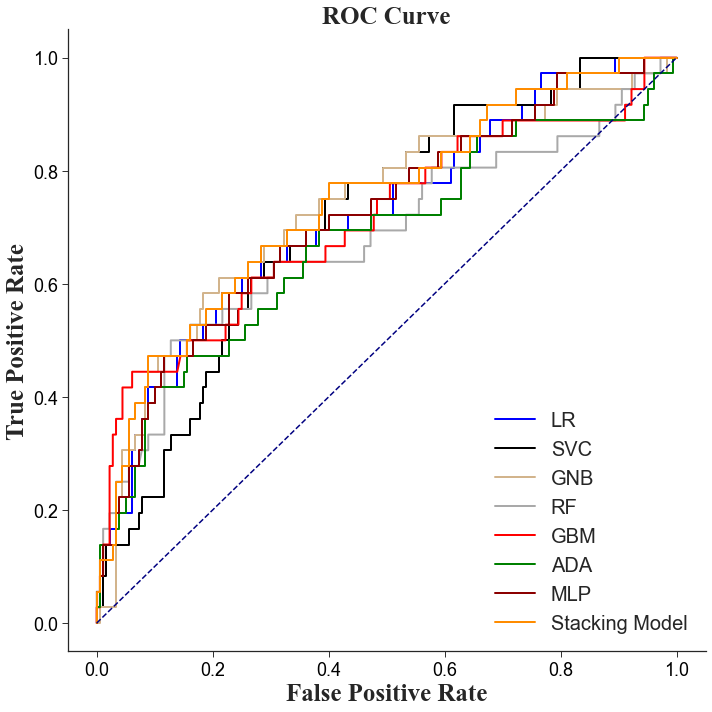

In [33]:
from ClinicalTools.metrics import plot_roc_curve

plot_roc_curve(models, X_test, y_test,
               colors=['blue', 'black', 'tan', 'darkgray', 'red', 'green', 'darkred', 'darkorange', 'deepskyblue'], 
               model_names=['LR', 'SVC', 'GNB', 'RF', 'GBM', 'ADA', 'MLP', 'Stacking Model'],
               save_path='./results/pics')

### Calibration Cruve

https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html

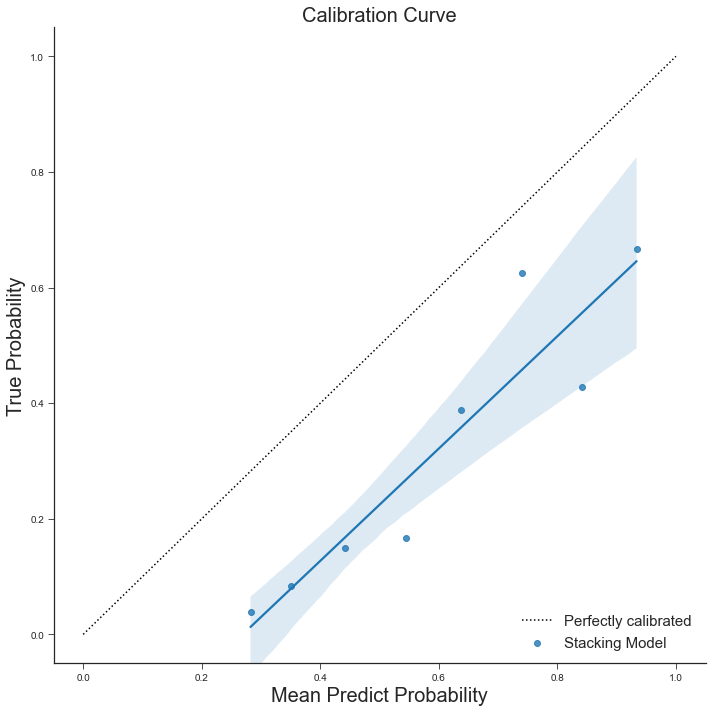

In [34]:
from ClinicalTools.metrics import plot_calibration_curve
plot_calibration_curve(stacking_clf, X_train, y_train, X_test, y_test,
                       name='Stacking Model', save_path='./results/pics',)

### Confusion Matrix

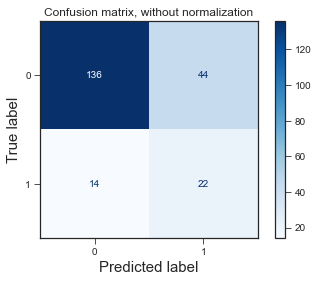

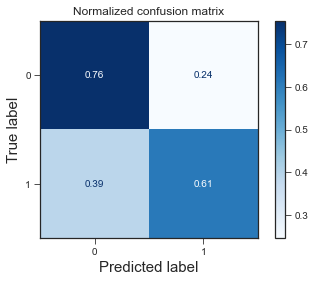

In [35]:
from ClinicalTools.metrics import plot_cm
import matplotlib.pyplot as plt

plot_cm(stacking_clf, X_test, y_test, class_names=['0', '1'], 
        cmap=plt.cm.Blues, save_path='./results/pics',)

# Shap

## Inverse Transform Data

- 需要返回原数值，force plot and decision plot 需要用到原值

In [36]:
X_train_raw = standard.inverse_transform(X_train)
X_test_raw = standard.inverse_transform(X_test)

## Initial Shap

In [37]:
from ClinicalTools.SHAP import SHAP

'''
stacking_clf : 预测模型
X_test_raw : 原始值 (用于后续绘图)
X_test: 标准化后的值
y_test: label
stacking_prediction: 预测值
explainer: 
    # 1. 树模型用 TreeExplainer
    # 2. 其他模型用 KernelExplainer
    # 3. 对最佳的模型进行SHAP就行
'''
shap = SHAP(stacking_clf, X_test_raw, X_test, y_test, stacking_prediction, explainer='kernel')

Using 216 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


SHAP is starting...



Finish! Consume Time: 0:01:14



## Summary Plot

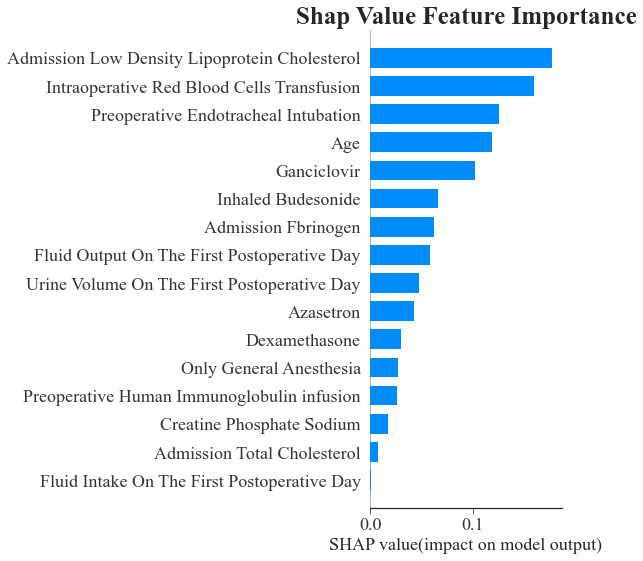

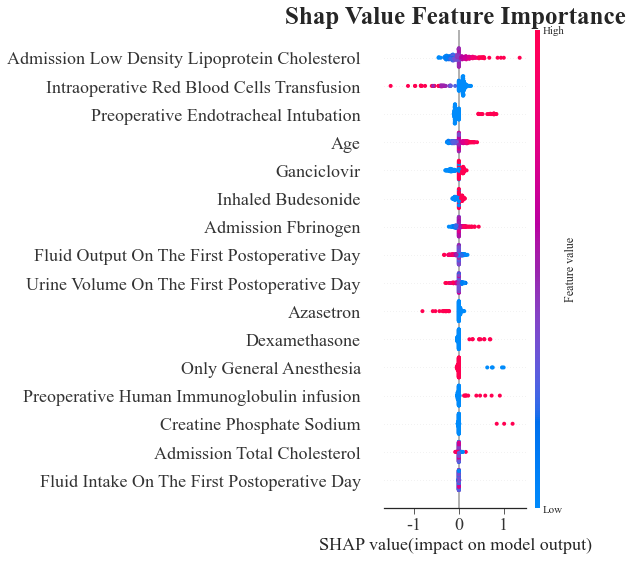

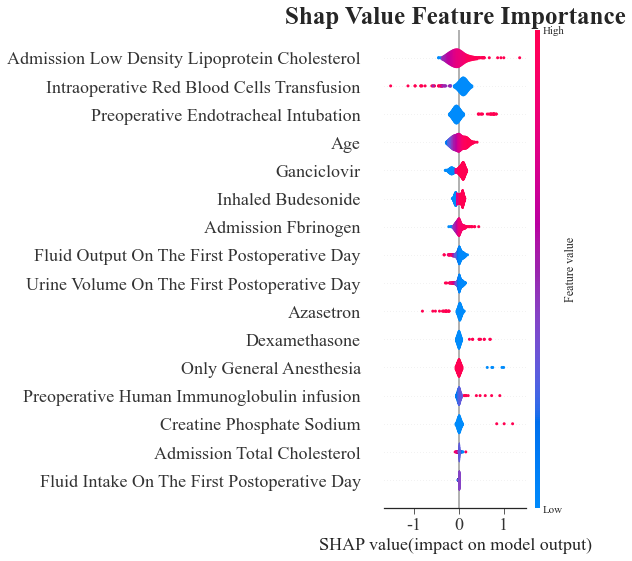

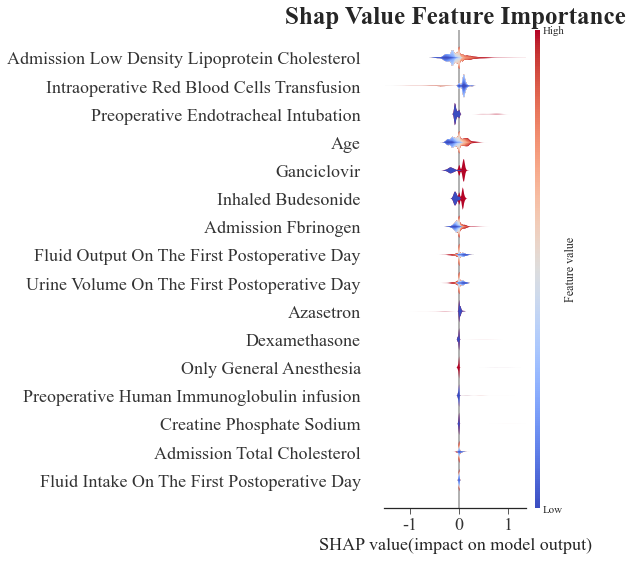

In [38]:
shap.summary_plot(save_path='./results/shap/summary/')

## Dependence Plot

In [39]:
shap.dependence_plot(save_path='./results/shap/dependence/')

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.89it/s]


## Force Plot

- **Force Plot 产生的图都是针对一个患者的结果**

### Generate Html File

- 首先，我们先生成得到 HTML 文件，再使用 selenium 来截图（因为直接使用 matplotlib 版本的图，样式不是特别好看）

In [40]:
shap.force_plot(save_path='./results/shap/force/html')

100%|█████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 399.88it/s]


### Html to Png

- 目的：使用 selenium 将 HTML 转为 PNG；
- chromedriver 要下载对应的 Chrome 版本，Here, the version is 91.0.4472.124 (download link: https://sites.google.com/a/chromium.org/chromedriver/downloads);
- 运行时**不用动计算机**，需要消耗大约20~30min（视样本数而定）。

In [41]:
!pip install selenium

Looking in indexes: https://pypi.douban.com/simple


In [43]:
from ClinicalTools.SHAP import html2png
html2png(chromedriver='./ClinicalTools/SHAP/chromedriver.exe')

## Decision Plot

- **Decision Plot 产生的图都是针对一个患者的结果**；
- feature_order 的排序是倒叙，建议跑出默认顺序后，用一张记录一下每个变量对应的序号。可以在源码里面修改这个 featrue order 的顺序（也是根据需求来改）

In [44]:
shap.decision_plot(save_path='./results/shap/decision')

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:48<00:00,  1.19it/s]


## Use Top Five Features (Test)

- 使用 top 3 或 top 5 变量建模一次，看看结果，有些文章需要放，reviewer会问：只用最重要的几个变量，结果如何？

In [45]:
top_five_vars = ['Admission Low Density Lipoprotein Cholesterol',
                  'Intraoperative Red Blood Cells Transfusion',
                  'Preoperative Endotracheal Intubation',
                  'Age', 'Ganciclovir']

In [46]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
estimators = [
    ('lr', models[0]),
    ('SVC', models[1]),
    ('GNB', models[2]),
    ('MLP', models[6]),
]

stacking_clf2 = StackingClassifier(estimators=estimators, final_estimator=models[0])

stacking_clf2.fit(X_train[top_five_vars], y_train)
stacking_prob2 = stacking_clf2.predict_proba(X_test[top_five_vars])[:, 1]
stacking_prediction2 = stacking_clf2.predict(X_test[top_five_vars])

print(auc_acc_sen_spe_f1_scores(y_test, stacking_prediction2, stacking_prob2))

        AUC  Accuracy        F1  Sensitivity  Specificity
0  0.651852  0.638889  0.338983     0.555556     0.655556


# Validation Set

- 外部验证数据集的流程与前面的一致；
- 需要注意是: （1）DataFrame 列的顺序是否和 Training Set一致？；（2）标准化的结果是否正确？；（3）是否有缺失？（一般采用均值补全）

## Load Data

In [47]:
validation_data = pd.read_excel('./data/validation.xlsx').drop('性别', axis=1)
for n in ['术后肺炎', '地塞米松', '布地奈德', '更昔洛韦', 
          '术前气管插管', '是否单纯全麻', '磷酸肌酸', '阿扎司琼']:
    validation_data[n] = validation_data[n].map({'是': 1, '否': 0})

## Rename Columns

In [48]:
eng_names = pd.read_excel('./data/中英文对照表.xls')

chi = eng_names['validation名称']
eng = eng_names['英文名称']

for c,e in zip(chi, eng):
    validation_data.rename(columns={
        c: e
    }, inplace=True)

In [49]:
train.rename(columns={'术后并发症_呼吸系统_肺炎_术后并发症名称': '术后肺炎'}, inplace=True)
train.drop(['Compound Methoxyphenamine Hydrochloride', 'Adrenaline'], axis=1, inplace=True)

## Split X and y

In [50]:
val_x = validation_data.drop('术后肺炎', axis=1)
val_y = validation_data['术后肺炎']

val_x = val_x[X_train.columns]

## Missing Value Filling

In [51]:
'''观察出，缺的是连续变量，直接使用 Training Set 的均值来补'''
val_x.fillna(X_train.mean(), inplace=True)
for n in val_x.columns:
    print(n ,val_x[n].isna().sum())

Age 0
Preoperative Human Immunoglobulin infusion 0
Intraoperative Red Blood Cells Transfusion 0
Admission Fbrinogen 0
Admission Total Cholesterol 0
Admission Low Density Lipoprotein Cholesterol 0
Urine Volume On The First Postoperative Day 0
Fluid Output On The First Postoperative Day 0
Fluid Intake On The First Postoperative Day 0
Dexamethasone 0
Inhaled Budesonide 0
Ganciclovir 0
Only General Anesthesia 0
Creatine Phosphate Sodium 0
Azasetron 0
Preoperative Endotracheal Intubation 0


## Cheak Training Set and Validation Set

In [52]:
val_data = pd.concat([val_x, val_y], axis=1)
sta_df = base_sta(train, val_data)
sta_df

,Characteristics,Subtype,train,test,p_values
10,Azasetron,0.0,474(94.61%),61(52.14%),1.88738e-15
11,Azasetron,1.0,27(5.39%),56(47.86%),1.88738e-15
8,Creatine Phosphate Sodium,0.0,493(98.4%),101(86.32%),0.11434
9,Creatine Phosphate Sodium,1.0,8(1.6%),16(13.68%),0.11434
0,Dexamethasone,0.0,460(91.82%),112(95.73%),0.997299
1,Dexamethasone,1.0,41(8.18%),5(4.27%),0.997299
5,Ganciclovir,0.0,191(38.12%),78(66.67%),2.52854e-07
4,Ganciclovir,1.0,310(61.88%),39(33.33%),2.52854e-07
3,Inhaled Budesonide,0.0,232(46.31%),47(40.17%),0.842028
2,Inhaled Budesonide,1.0,269(53.69%),70(59.83%),0.842028


## Standardzation

In [53]:
val_x = standard.transform(val_x)

## Bootstrap Scores

- 一般只用best performance model 就可以，本例只要放看 stacking model 的结果；
- 同时，需要看 validation set 的效果如何，如果太差，就不建议第一步就放，需要结局情况：
    - 补数据（正负样本偏差大）；
    - 检查数据的采集是否与 Training Set AND Test set 有很大的差距（需与医生沟通）；
    - 重新建模（意义不大）；

In [54]:
bootstrap_df_val = bootstrap(val_x, val_y, models,
                             index_names=['LR', 'SVC', 'GNB', 'RF', 'GBM', 'ADA', 'MLP', 'Stacking model'],
                             precision=3)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.12it/s]


In [55]:
bootstrap_df_val

,AUC,Accuracy,Sensitivity,Specificity,F1
LR,"0.617(0.465, 0.75)","0.419(0.325, 0.513)","0.833(0.615, 1.0)","0.35(0.26, 0.444)","0.291(0.174, 0.411)"
SVC,"0.598(0.428, 0.756)","0.581(0.487, 0.675)","0.706(0.476, 0.909)","0.56(0.461, 0.663)","0.324(0.176, 0.471)"
GNB,"0.618(0.483, 0.739)","0.59(0.496, 0.684)","0.353(0.133, 0.6)","0.63(0.529, 0.723)","0.197(0.067, 0.339)"
RF,"0.68(0.537, 0.804)","0.624(0.538, 0.709)","0.769(0.538, 0.938)","0.605(0.51, 0.691)","0.371(0.222, 0.512)"
GBM,"0.533(0.397, 0.661)","0.615(0.521, 0.701)","0.231(0.055, 0.467)","0.677(0.592, 0.765)","0.143(0.037, 0.286)"
ADA,"0.624(0.472, 0.751)","0.675(0.59, 0.752)","0.167(0.0, 0.368)","0.757(0.67, 0.842)","0.13(0.0, 0.267)"
MLP,"0.545(0.376, 0.702)","0.615(0.521, 0.701)","0.4(0.176, 0.667)","0.654(0.557, 0.747)","0.233(0.087, 0.382)"
Stacking model,"0.541(0.393, 0.683)","0.453(0.368, 0.547)","0.714(0.5, 0.929)","0.412(0.31, 0.514)","0.273(0.144, 0.387)"


## ROC AND SHAP

In [56]:
'''
ROC, Calibration Cruve, Confusion Matrix；
SHAP 一般不需要，只用放 test set 的结果；
'''

'\nROC, Calibration Cruve, Confusion Matrix；\nSHAP 一般不需要，只用放 test set 的结果；\n'